# Rolling Disc with 3D Visualization

In [1]:
import sympy as sm
import sympy.physics.mechanics as me

In [2]:
me.init_vprinting(use_latex=True, pretty_print=False)

# Constants

- $m$: mass of the thin disc
- $r$: radius of the thin disc
- $g$: acceleration due to gravity

In [3]:
m, r, g = sm.symbols('m, r, g')

# Generalized Coordinates and Speeds

- $q_1$: yaw angle
- $q_2$: roll angle
- $q_3$: pitch (spin) angle
- $x$: location of the ground/wheel contact point in the ground plane
- $y$: location of the ground/wheel contact point in the ground plane

In [4]:
q1, q2, q3, x, y = me.dynamicsymbols('q1, q2, q3, x, y')

In [5]:
u1, u2, u3, vx, vy = me.dynamicsymbols('u1, u2, u3, v_x, v_y')

# Reference Frames

In [6]:
N = me.ReferenceFrame('N')

Yaw

In [7]:
Y = N.orientnew('Y', 'Axis', (q1, N.z))

Roll

In [8]:
L = Y.orientnew('L', 'Axis', (q2, Y.y))

Pitch (spin)

In [9]:
R = L.orientnew('R', 'Axis', (q3, L.x))

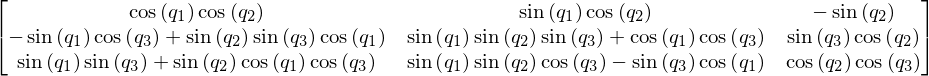

In [10]:
sm.trigsimp(R.dcm(N))

In [11]:
#R = N.orientnew('R', 'Body', (q1, q2, q3), 'ZYX')  # equivalent to above
#R.dcm(N)

# Angular Velocity and Kinematic Differential Equations

Calculate the angular velocity of $R$ in $N$ automatically based on the orientation and express in the $L$ frame and store the resulting vector in a variable.

In [12]:
w_R_N_qd = R.ang_vel_in(N)
w_R_N_qd.express(L)

Now overwrite the angular velocity of $R$ in $N$ to be in terms of the generalized speeds that we desire. In this case, we choose the generalized speeds to be the measure numbers of the angular velocity of $R$ in $N$ and the time derivatives of $x$ and $y$.

In [13]:
R.set_ang_vel(N, u1 * L.x + u2 * L.y + u3 * L.z)
R.ang_vel_in(N)

Now we can calculate the kinematical differential equations for the first three generalized speeds.

In [14]:
kd = [me.dot(R.ang_vel_in(N) - w_R_N_qd, uv) for uv in L]
kd

Append the simple defintion of the remaining speeds, $v_x$ and $v_y$.

In [15]:
kd = kd + [vx - x.diff(), vy - y.diff()]
kd

Solve the kinematrical differential equations for the derivatives of the coordinates, which expresses these in explicit first order form.

In [16]:
qdots = sm.solve(kd, q1.diff(), q2.diff(), q3.diff(), x.diff(), y.diff())

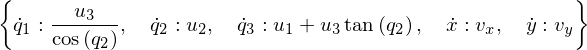

In [17]:
qdots

Ensure there are no time derivatives of the coordinates.

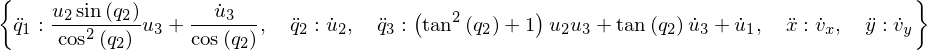

In [18]:
qddots = {k.diff(): v.diff(me.dynamicsymbols._t).subs(qdots) for k, v in qdots.items()}
qddots

# Points

Fixed origin:

In [19]:
No = me.Point('No')
No.set_vel(N, 0)

C is the contact point, the following definition of position says that $C$ is the point moving in $N$ that is always at the location of contact between the wheel and the ground.

In [20]:
C = No.locatenew('C', x * N.x + y * N.y)

$R_o$ is the mass center and centroidal center of the disc.

In [21]:
Ro = C.locatenew('Ro', r * L.z)
Ro.pos_from(No)

# Linear Velocities

We want these velocities to be in terms of the generalized coordinates and speeds only, so make some subsitutions.

In [22]:
C.set_vel(N, vx * N.x + vy * N.y)

In [23]:
v_Ro_N = Ro.v2pt_theory(C, N, L)
v_Ro_N

In [24]:
Ro.set_vel(N, v_Ro_N.subs(qdots))
Ro.vel(N)

# Linear accelerations

In [25]:
a_Ro_N = Ro.a2pt_theory(C, N, L)
a_Ro_N

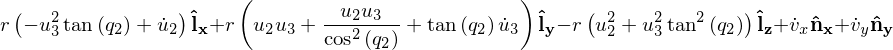

In [26]:
a_Ro_N.subs(qddots).subs(qdots).simplify()

In [27]:
Ro.set_acc(N, a_Ro_N.subs(qddots).subs(qdots))

# Velocity constraints

There is a rolling without slip velocity constraint between the disc and the ground. If the velocity of a point at $C$ which is fixed in $R$ is computed, then the components of this velocity in the ground plane must be equal to zero.

In [28]:
v_C_N = Ro.vel(N) + R.ang_vel_in(N).cross(C.pos_from(Ro))
v_C_N

In [29]:
con1 = v_C_N.dot(Y.x)
con1

In [30]:
con2 = v_C_N.dot(Y.y)
con2

In [31]:
vel_cons = [con1, con2]

We have two velocity constraint equations, so we can solve for the two dependent speeds. Choosing $v_x,v_y$ as the dependent generalized speeds.

In [32]:
dep_speeds = sm.solve(vel_cons, vx, vy)
dep_speeds

Now substitute these expressions for all of the depdendent speeds in all important velocities and accelerations.

In [33]:
Ro.vel(N)

In [34]:
Ro.set_vel(N, Ro.vel(N).subs(dep_speeds))
Ro.vel(N)

In [35]:
R.ang_vel_in(N)

In [36]:
Ro.acc(N)

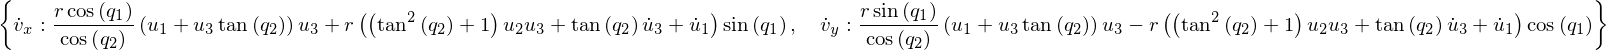

In [37]:
t = me.dynamicsymbols._t
dep_accs = {k.diff(): v.diff(t).subs(qdots) for k, v in dep_speeds.items()}
dep_accs

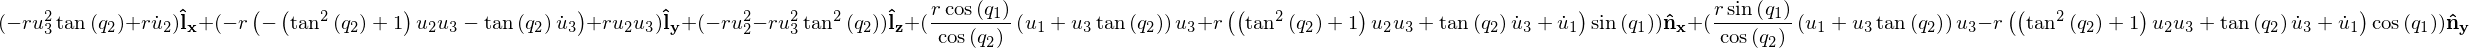

In [38]:
Ro.set_acc(N, Ro.acc(N).subs(dep_accs).subs(dep_speeds))
Ro.acc(N)

# Generalized Active Forces

Gravity is the only contributing force.

In [39]:
loads = [(Ro, -m * g * N.z)]

# Generalized Active Inertias

Assuming that body $R$ is a thin flat disc the inertia can constructed. The spin axis, body fixed $X$, has the larger moment of inertia.

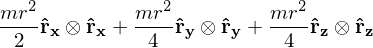

In [40]:
I = me.inertia(R, m / 2 * r**2, m / 4 * r**2, m / 4 * r**2)
I

In [41]:
disc = me.RigidBody('disc', Ro, R, m, (I, Ro))

In [42]:
bodies = [disc]

# Kane's Equations

In [43]:
kane = me.KanesMethod(N,
                      q_ind=(q1, q2, q3, x, y),
                      u_ind=(u1, u2, u3),
                      kd_eqs=kd,
                      u_dependent=(vx, vy),
                      velocity_constraints=vel_cons)

In [44]:
fr, frstar = kane.kanes_equations(bodies, loads)

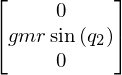

In [45]:
fr

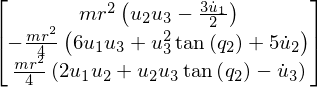

In [46]:
frstar = sm.trigsimp(frstar)
frstar

# Ignorable coordinates

Note that only a single coordinate, the roll angle, is found in the euqations of motion. This meands that the yaw angle, pitch angle, and the location of the disc on the plane are all ignorable coordinates and do not govern the fundamental motion of the disc.

In [47]:
me.find_dynamicsymbols(fr)

In [48]:
me.find_dynamicsymbols(frstar)

# Put into explicit first order form

In [49]:
zero = sm.trigsimp(fr + frstar)

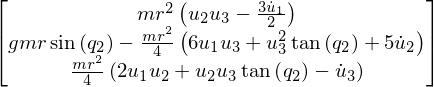

In [50]:
zero

First put the dynamical equations in first order form.

In [51]:
u = sm.Matrix([u1, u2, u3])

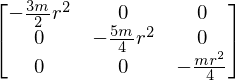

In [52]:
M = zero.jacobian(u.diff())
M

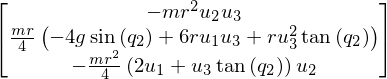

In [53]:
G = sm.simplify(M * u.diff() - zero)
G

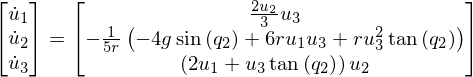

In [54]:
udots = M.LUsolve(G)
sm.Eq(u.diff(), udots)

In [55]:
me.find_dynamicsymbols(udots)

Now we can add in the kinematical equations. Note that the depdendent speeds expressions can be substituted into the kinematical differential equations.

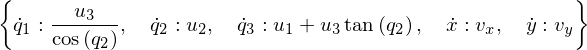

In [56]:
qdots

In [57]:
dep_speeds

Now stack all of the right hand side expressions together.

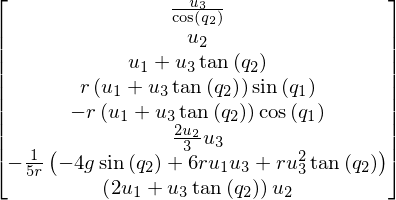

In [58]:
rhs = sm.Matrix([qdots[q1.diff()], qdots[q2.diff()], qdots[q3.diff()]]).\
      col_join(sm.Matrix([dep_speeds[vx], dep_speeds[vy]])).\
      col_join(udots)
rhs

The explicity first order form of the equations of motion of the system (including equations for the ignorable coordinates) are as follows:

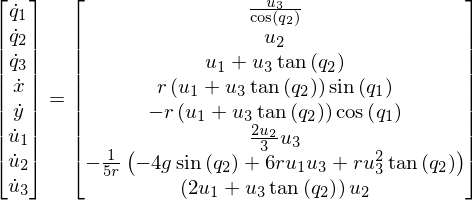

In [59]:
states = [q1, q2, q3, x, y, u1, u2, u3]
sm.Eq(sm.Matrix(states).diff(), rhs)

# Integrate the equations of motion

In [60]:
import numpy as np
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function

Generate a function that evaluates the right hand side of the differential equations.

In [61]:
eval_rhs = generate_ode_function(rhs, [q1, q2, q3, x, y], [u1, u2, u3], [m, r, g])

In [62]:
type(eval_rhs)

function

In [63]:
help(eval_rhs)

Help on function rhs in module pydy.codegen.ode_function_generators:

rhs(*args)
    Returns the derivatives of the states, i.e. numerically evaluates the right
    hand side of the first order differential equation.
    
    x' = f(x, t, p)
    
    Parameters
    x : ndarray, shape(8,)
        The state vector is ordered as such:
            - q1(t)
            - q2(t)
            - q3(t)
            - x(t)
            - y(t)
            - u1(t)
            - u2(t)
            - u3(t)
    t : float
        The current time.
    p : dictionary len(3) or ndarray shape(3,)
        Either a dictionary that maps the constants symbols to their numerical
        values or an array with the constants in the following order:
            - m
            - r
            - g
    
    Returns
    dx : ndarray, shape(8,)
        The derivative of the state vector.



We will need some initial conditions. Note that if $u_3$ is zero then $u_1$ sets the disc's pitch/spin rate. Set the roll angle to be have a slight deviation from vertical.

In [64]:
x0 = np.array([0, np.deg2rad(3), 0, 0, 0, np.deg2rad(100), 0, 0])

In [65]:
p = {m: 1.0, r: 1.0, g: 9.81}

In [66]:
eval_rhs(x0, 2.6, p)

array([ 0.        ,  0.        ,  1.74532925,  0.        , -1.74532925,
        0.        ,  0.41073258,  0.        ])

In [67]:
%timeit eval_rhs(x0, 1.0, p)

176 µs ± 63.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Integrate the equations over a time span.

In [68]:
times = np.linspace(0, 20.0, num=20*60)

In [69]:
traj = odeint(eval_rhs, x0, times, args=(p, ))

# Plot the trajectory

In [70]:
import matplotlib.pyplot as plt

In [71]:
%matplotlib notebook

<IPython.core.display.Javascript object>


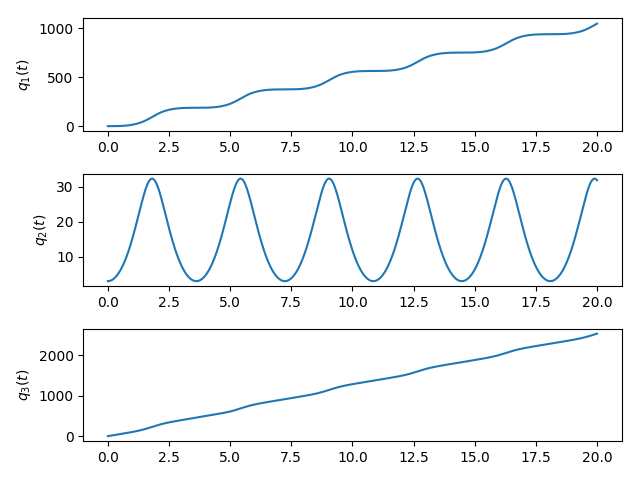

In [72]:
fig, axes = plt.subplots(3, 1)

for i, ax in enumerate(axes):
    ax.plot(times, np.rad2deg(traj[:, i]))
    ax.set_ylabel(sm.latex(states[i], mode='inline'))
    
plt.tight_layout()

Check out the ground trace.

<IPython.core.display.Javascript object>


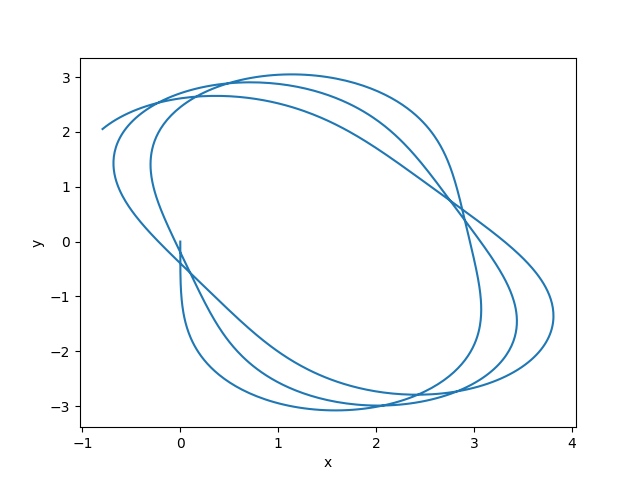

In [73]:
fig, ax = plt.subplots(1, 1)
ax.plot(traj[:, 3], traj[:, 4])
ax.set_xlabel('x')
ax.set_ylabel('y');

# 3D Visualization

In [74]:
from pydy.viz import Plane, Cylinder, Scene, VisualizationFrame

In [75]:
ground = Plane(20.0, 20.0, color='blue')
disc_cyl = Cylinder(0.001, 1.0, color='red', material='checkerboard')

In [76]:
vf1 = VisualizationFrame('ground', N, No, ground)
vf2 = VisualizationFrame('disc', R.orientnew('R', 'Axis', (sm.pi/2, R.z)), Ro, disc_cyl)

In [77]:
scene = Scene(N, No, vf1, vf2,
              times=times,
              states_symbols=[q1, q2, q3, x, y, u1, u2, u3],
              states_trajectories=traj,
              constants={m: 1.0, r: 1.0, g: 9.81})

In [78]:
scene.display_ipython()